# Sentiment Analysis — IMDB Movie Reviews
**Author:** Raihan Lazuardi  
**Purpose:** Baseline Sentiment Analysis pipeline using TF-IDF + Logistic Regression.  


**How to use**
1. Run the **Setup** cell below (it installs required packages and shows versions).  
2. Run cells in order: Load Data → EDA → Preprocessing → Feature Extraction (TF-IDF) → Modeling → Evaluation → Demo Inference.  




In [5]:
# Jalankan cell ini sebelu, menjalankan cell yg lain
# Tujuan:
# - Mengecek apakah semua library sudah terinstal
# - Menampilkan versi library
# - Mengunduh resource NLTK yang dibutuhkan (stopwords & vader)


# Jika library kamu belum terinstal, bisa install dengan perintah berikut (hapus tanda #)
# !pip install pandas scikit-learn nltk matplotlib seaborn wordcloud joblib

import sys
import pandas as pd
import sklearn
import nltk
import joblib
import matplotlib
import seaborn as sns

# Versi library
print("Versi Python:", sys.version.split()[0])
print("Versi pandas:", pd.__version__)
print("Versi scikit-learn:", sklearn.__version__)
print("Versi NLTK:", nltk.__version__)
print("Versi joblib:", joblib.__version__)
print("Versi matplotlib:", matplotlib.__version__)
print("Versi seaborn:", sns.__version__)

# Mengunduh resource NLTK yang diperlukan
# - stopwords: digunakan untuk preprocessing text (menghapus kata umum)
# - vader_lexicon: digunakan jika ingin mencoba Sentiment Analyzer VADER

nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

print("NLTK siap digunakan.")


Versi Python: 3.12.12
Versi pandas: 2.2.2
Versi scikit-learn: 1.6.1
Versi NLTK: 3.9.1
Versi joblib: 1.5.2
Versi matplotlib: 3.10.0
Versi seaborn: 0.13.2
NLTK siap digunakan.


In [8]:
from google.colab import files
import pandas as pd

imdb = files.upload()
data = pd.read_csv('IMDB Dataset.csv')

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [9]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
data.columns

Index(['review', 'sentiment'], dtype='object')

**DATA CLEANING**

Bertujuan untuk membersihkan / memproses data teks karena model ML tidak bisa baca kalimat mentah



```
regex = re.sub(pattern, replacement, string_asal)
```



In [11]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#ambil stopwords bahasa inggris
stop_words = set(stopwords.words('english')) #set berguna untuk pencarian lebih cepat
important = {"not","no","nor","never"}
stop_words = stop_words - important
def clean_text(text):
  #buat semua text konsisten menjadi hurus kecil
  text = text.lower()

  #hapus html tags
  text = re.sub(r"<.*?>", " ", text)

  #hapus URL
  text = re.sub(r"http\S+|www\S+|https\S+", " ", text)

  #hapus karakter non huruf
  text = re.sub(r"[^a-z\s]", " ", text)

  tokens = text.split() #split teks jadi list kata
  #Hello World -> ["Hello", "World"]
  tokens = [w for w in tokens if len(w) > 1 and w not in stop_words] #buang kata yang tidak penting menggunakan stopwwords dan buang kata yang hanya punya panjang 1

  #gabung kembali kalimat
  return " ".join(tokens)

#ambil kolom 'review' dan bersihkan pakai fungsi clean_text dan simpan di kolom baru(clean)
data['clean'] = data['review'].apply(clean_text)

data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment,clean
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


**ENCODE**

Mengubah nama positive dan negative menjadi angka 1 dan 0 agar model ML mengerti

In [12]:
data['label'] = data['sentiment'].map({'positive': 1,'negative':0})
data[['sentiment','label']].head()

,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


**SPLIT TRAIN**



```
stratify=y
```
bertujuan untuk data validasi dan data training tetep seimbang


In [13]:
from sklearn.model_selection import train_test_split
X = data.clean
y = data.label

Train_X,Val_X,Train_Y,Val_Y = train_test_split(X,y,test_size=0.2,
                                               random_state = 42,
                                               stratify=y)

len(Train_X),len(Val_X)

(40000, 10000)

**TF - IDF**
(Term Freq - Inverse Document Freq)

The most important things TF-IDF

TF yang berarti sebarapa sering kemunculan kata dan IDF yang berarti seberapa jarang kemunculan kata

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 40000,
                        ngram_range = (1,2))

X_train_tfidf = tfidf.fit_transform(Train_X)

Val_X_tfid =tfidf.transform(Val_X)

X_train_tfidf.shape, Val_X_tfid.shape

((40000, 40000), (10000, 40000))

In [42]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter =1000,
    solver='saga'
)

model.fit(X_train_tfidf,Train_Y)

LogisticRegression(max_iter=1000, solver='saga')

In [43]:
from sklearn.metrics import accuracy_score,classification_report

y_pred = model.predict(Val_X_tfid)

print("Akurasi Model:", accuracy_score(Val_Y, y_pred))
print(classification_report(Val_Y, y_pred))

Akurasi Model: 0.9046
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5000
           1       0.90      0.91      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



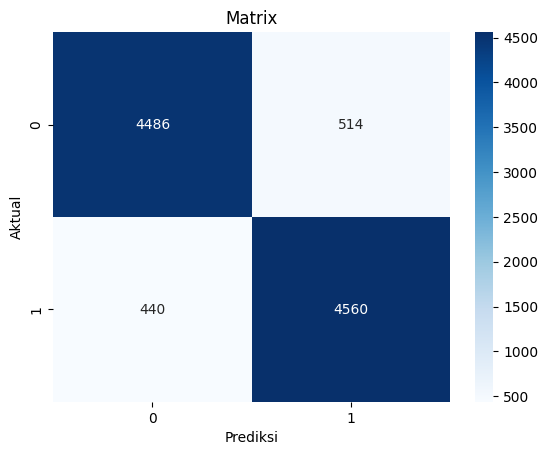

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Val_Y, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Matrix")
plt.show()


In [45]:
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
coef = model.coef_[0]

top_positive = feature_names[np.argsort(coef)[-20:]]
top_negative = feature_names[np.argsort(coef)[:20]]

print("Kata Kata Positif:\n", top_positive)
print("Kata Kata Negatif:\n", top_negative)


Kata Kata Positif:
 ['enjoyable' 'still' 'superb' 'definitely' 'today' 'love' 'well'
 'favorite' 'enjoyed' 'hilarious' 'one best' 'brilliant' 'fun' 'loved'
 'amazing' 'wonderful' 'best' 'perfect' 'excellent' 'great']
Kata Kata Negatif:
 ['worst' 'bad' 'awful' 'waste' 'boring' 'poor' 'terrible' 'nothing'
 'horrible' 'worse' 'dull' 'poorly' 'stupid' 'minutes' 'instead'
 'unfortunately' 'no' 'fails' 'script' 'supposed']


## Demo Inference
This cell shows how to load a saved `model_baseline.pkl` (saved with `joblib.dump({'tfidf': tfidf, 'model': clf}, 'models/model_baseline.pkl')`)
and run a quick prediction example.

If you don't have a saved model in `models/model_baseline.pkl`, the cell will show instructions to run training first.

In [55]:
# run after u hv trained & saved the model to models/model_baseline.pkl
import joblib
from pathlib import Path

model_path = Path("models/model_baseline.pkl")
def predict_text(text):
    from IPython.display import display
    try:
        obj = joblib.load(model_path)
        tfidf = obj['tfidf']
        model = obj['model']
    except Exception as e:
        print("could not load models/model_baseline.pkl. If u haven't saved the model, run the training cells and save with joblib.")
        print("error details:", e)
        raise

    # we assume the notebook contains a 'clean_text' function used for preprocessing.
    try:
        clean = clean_text(text)
    except NameError:
        print("clean_text function is not found in the notebook namespace. Make sure to run the preprocessing cell that defines clean_text.")
        clean = text

    v = tfidf.transform([clean])
    pred = model.predict(v)[0]
    proba = model.predict_proba(v).max() if hasattr(model, 'predict_proba') else None
    label = 'positive' if pred == 1 else 'negative'
    print("Text:", text)
    print("Cleaned:", clean)
    print("Prediction:", label, "| Confidence:", proba)
    return pred, proba




#EXAMPLE

In [50]:
import os
import joblib
os.makedirs("models", exist_ok=True)
joblib.dump({'tfidf': tfidf, 'model': model}, 'models/model_baseline.pkl')


['models/model_baseline.pkl']

In [56]:
predict_text("this movie was really amazing and thrilling!")


Text: this movie was really amazing and thrilling!
Cleaned: movie really amazing thrilling
Prediction: positive | Confidence: 0.8741895570187046


(np.int64(1), np.float64(0.8741895570187046))

In [57]:
predict_text("the plot was boring and predictable")

Text: the plot was boring and predictable
Cleaned: plot boring predictable
Prediction: negative | Confidence: 0.9883283218792469


(np.int64(0), np.float64(0.9883283218792469))